# Plot for HW 8
## Sofiya Elyukin

#### I used a dataset from the CUSP Data Faility. The dataset contains all trip records for NYC green taxis in 2015. It can also be found on the NYC Open Data Website at https://data.cityofnewyork.us/Transportation/2015-Green-Taxi-Trip-Data/gi8d-wdg5.

In [1]:
# Import packages for notebook
from __future__ import print_function, division
import pandas as pd
import os
import pylab as pl
import json
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

# Load json file which sets parameters for plots
s = json.load( open(os.getenv('PUI2016')+'/matplotlibrc.json') )
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Access data from the data facility
#trips = pd.read_csv(os.getenv('DFDATA') + '/gi8d-wdg5/1444926845/gi8d-wdg5')

# Acces data from data facility and save to PUIdata folder (and renaming for clarity)
os.system("cp " + os.getenv('DFDATA') + '/gi8d-wdg5/1444926845/gi8d-wdg5 ' + os.getenv("PUIDATA") + "/GreenTaxi2015")
trips = pd.read_csv(os.getenv("PUIDATA") + '/GreenTaxi2015')

In [3]:
# Take a look at the dataset
print ('Number of rows =', len(trips))
print (trips.columns)
trips.head(3)

Number of rows = 11534883
Index([u'pickup_datetime', u'dropoff_datetime', u'Store_and_fwd_flag',
       u'rate_code', u'Dropoff_latitude', u'Passenger_count', u'Trip_distance',
       u'Fare_amount', u'Extra', u'MTA_tax', u'Tip_amount', u'Tolls_amount',
       u'Ehail_fee', u'Total_amount', u'Payment_type', u'Trip_type',
       u'Pickup_longitude', u'Pickup_latitude', u'Dropoff_longitude',
       u'vendorid', u'Improvement_surcharge'],
      dtype='object')


,pickup_datetime,dropoff_datetime,Store_and_fwd_flag,rate_code,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,...,Tolls_amount,Ehail_fee,Total_amount,Payment_type,Trip_type,Pickup_longitude,Pickup_latitude,Dropoff_longitude,vendorid,Improvement_surcharge
0,01/27/2015 07:30:40 PM,01/27/2015 07:47:34 PM,N,1,40.842724,1,1.67,11.5,1.0,0.5,...,0.0,NaN,13.3,2,1.0,-73.920158,40.835316,-73.914696,2,0.3
1,01/09/2015 03:45:22 PM,01/09/2015 03:54:32 PM,N,1,40.679829,3,1.15,7.5,0.0,0.5,...,0.0,NaN,9.8,1,1.0,-73.985672,40.669933,-73.998367,2,0.3
2,01/16/2015 10:07:38 PM,01/16/2015 10:14:25 PM,N,1,40.736202,1,1.74,7.5,0.5,0.5,...,0.0,NaN,8.8,2,1.0,-73.892570,40.746658,-73.909294,2,0.3


In [4]:
# Check type for columns of interest
print (type(trips['Trip_distance'][0]), type(trips['Tip_amount'][0]),
       type(trips['pickup_datetime'][0]), type(trips['Fare_amount'][0]))

<type 'numpy.float64'> <type 'numpy.float64'> <type 'str'> <type 'numpy.float64'>


In [5]:
# 11 million records is too many, wanted to take just a month or two of records.
# Required converting date column from type string to type datetime.
# trips['Pickup'] = pd.to_datetime(trips['pickup_datetime']) --> canceled because taking too long with 11 million records

# Checked to see how many records for January, discovered that the entire dataset in fact is just for January:
attempt = trips[(trips['pickup_datetime'] <= '01/31/2015 11:59:59 PM')]
print ('Trips in January:', len(attempt))
attempt = trips[(trips['pickup_datetime'] >= '02/01/2015 00:00:01 AM')]
print ('Trips from February through December:', len(attempt))
# Test on the off-chance the notebook wasn't reading the strings the way I thought it was supposed to:
attempt = trips[(trips['pickup_datetime'] <= '01/10/2015 11:59:59 PM')]
print ('Trips through January 10th:', len(attempt))

Trips in January: 11517607
Trips from February through December: 0
Trips through January 10th: 3780911


In [6]:
# Decided to create a subsample just by slicing the dataset.
tripSample = trips[::2000]
len(tripSample)

5768

In [7]:
# Want to look at how trip distance might affect the tip ammount. Dropped all other columns.
tripSample = tripSample[['Trip_distance', 'Tip_amount']]
tripSample.head()

,Trip_distance,Tip_amount
0,1.67,0.0
2000,2.32,0.0
4000,3.35,0.0
6000,0.91,0.0
8000,4.30,0.0


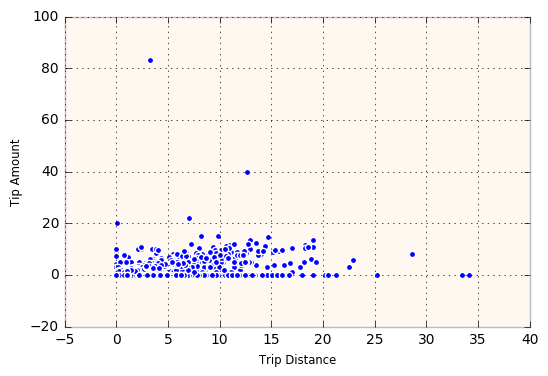

In [8]:
# Just an initial plot to "get the lay of the land" before determining what else needs to be done
pl.scatter(tripSample['Trip_distance'], tripSample['Tip_amount'])
pl.xlabel('Trip Distance')
pl.ylabel('Tip Amount')

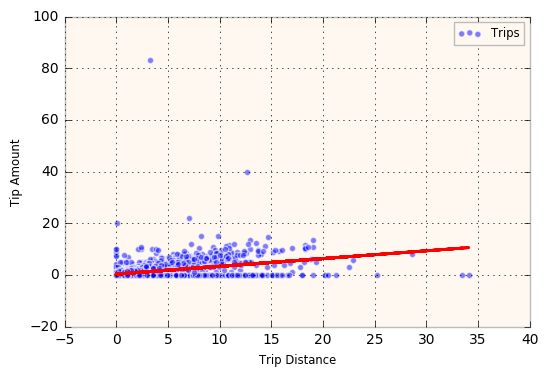

In [9]:
# See what a fitted line looks like
x=tripSample['Trip_distance']
y=tripSample['Tip_amount']

(m,b) = polyfit(x,y,1)
yp = polyval([m,b],x)

pl.scatter(tripSample['Trip_distance'], tripSample['Tip_amount'], label='Trips', alpha=0.5)
pl.xlabel('Trip Distance')
pl.ylabel('Tip Amount')
pl.legend(loc=0)
pl.plot(x, yp, color="red")

In [10]:
# Cut out the outliers
tripSample = tripSample[((tripSample['Trip_distance'] <= 25) & (tripSample['Tip_amount'] < 40))]

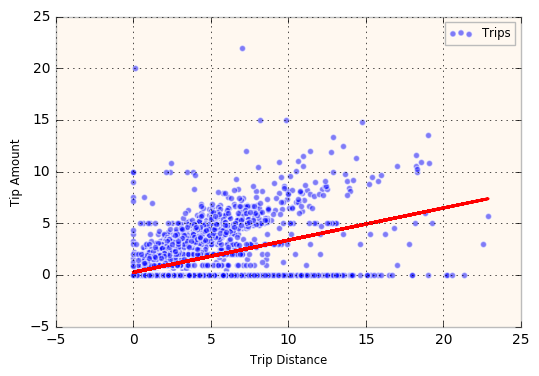

In [11]:
x=tripSample['Trip_distance']
y=tripSample['Tip_amount']

(m,b) = polyfit(x,y,1)
yp = polyval([m,b],x)

pl.scatter(tripSample['Trip_distance'], tripSample['Tip_amount'], label='Trips', alpha=0.5)
pl.xlabel('Trip Distance')
pl.ylabel('Tip Amount')
pl.legend(loc=0)
pl.plot(x, yp, color="red")

In [12]:
# Drop zeros for distance because trips shouldn't be longer than 0, and for tip because it's skewing the data
tripSample2 = tripSample[((tripSample['Trip_distance'] > 0) & (tripSample['Tip_amount'] >0))]

## The Final Plot

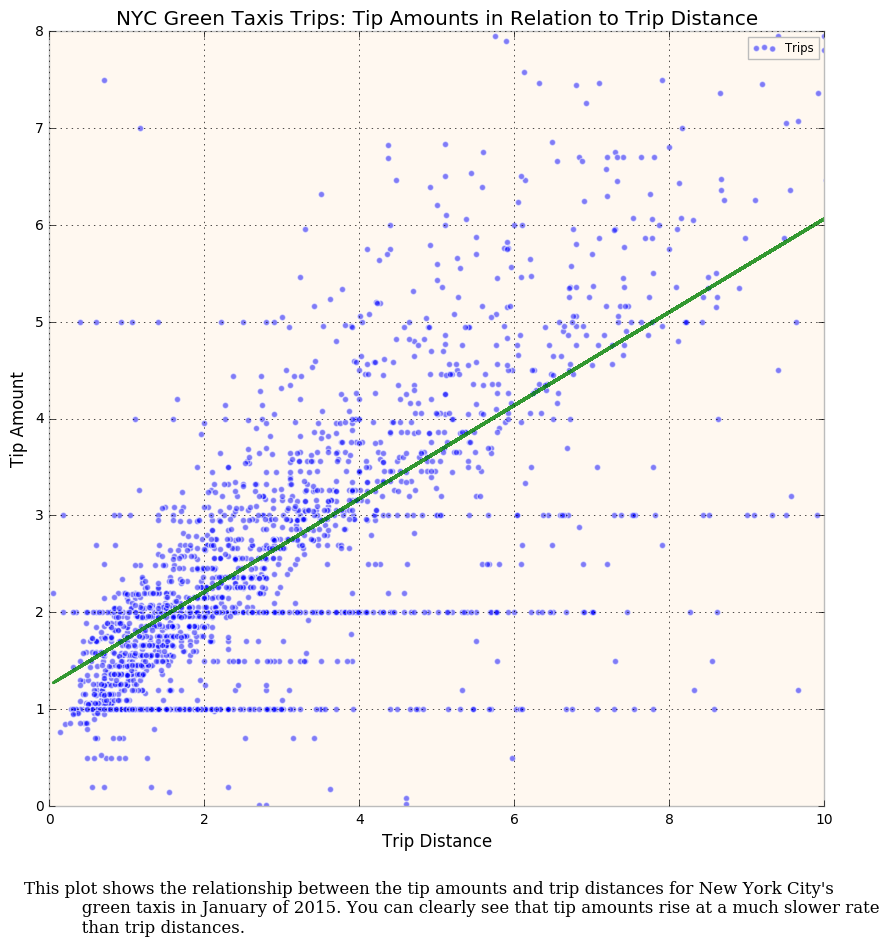

In [56]:
x=tripSample2['Trip_distance']
y=tripSample2['Tip_amount']

(m,b) = polyfit(x,y,1)
yp = polyval([m,b],x)

pl.figure(figsize=(10,10))
pl.scatter(tripSample2['Trip_distance'], tripSample2['Tip_amount'], label='Trips', alpha=0.5)
pl.xlabel('Trip Distance', fontsize = 'large')
pl.ylabel('Tip Amount', fontsize = 'large')
pl.title('NYC Green Taxis Trips: Tip Amounts in Relation to Trip Distance', fontsize = 'x-large')
pl.legend(loc=0)
pl.plot(x, yp, 'green', alpha = 0.8)
# zoom in on plot
pl.xlim(0, 10)
pl.ylim(0, 8)
pl.figtext(0.1, -.0009,'''This plot shows the relationship between the tip amounts and trip distances for New York City's
           green taxis in January of 2015. You can clearly see that tip amounts rise at a much slower rate
           than trip distances.''', fontsize='large', fontname = 'serif')